In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.algorithms import EstimationProblem, IterativeAmplitudeEstimation
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.jupyter import *
from qiskit.utils import QuantumInstance
from qiskit.visualization import *
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications import EuropeanCallPricing

from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [2]:
from functools import wraps
import inspect

def initializer(func):
    """
    tool from https://stackoverflow.com/a/1389216
    Automatically assigns the parameters.

    >>> class process:
    ...     @initializer
    ...     def __init__(self, cmd, reachable=False, user='root'):
    ...         pass
    >>> p = process('halt', True)
    >>> p.cmd, p.reachable, p.user
    ('halt', True, 'root')
    """
    names, varargs, keywords, defaults = inspect.getargspec(func)

    @wraps(func)
    def wrapper(self, *args, **kargs):
        for name, arg in list(zip(names[1:], args)) + list(kargs.items()):
            setattr(self, name, arg)

        if names and defaults:
            for name, default in zip(reversed(names), reversed(defaults)):
                if not hasattr(self, name):
                    setattr(self, name, default)

        func(self, *args, **kargs)

    return wrapper

In [3]:
spot = 2 # price of stock today
strike = 1.9

/tmp/ipykernel_257/2509001727.py:17: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  names, varargs, keywords, defaults = inspect.getargspec(func)


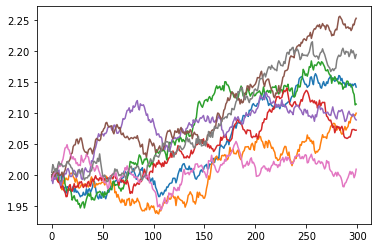

0.1494843118025212
(0.10520710740557082, 0.21921813539580032)


In [4]:
class MonteCarloSimulator:
    @initializer
    def __init__(self, M, stock_spot_price, drift, volatility, time_step, T):
        pass
    
    def simulate_paths(self):
        paths_til_maturity = []
        for i in range(self.M):
            path = []
            current_price = self.stock_spot_price
            for t in range(int(self.T/self.time_step)):
                brownian = np.random.normal(0, math.sqrt(self.time_step))
                price_change = self.drift*self.time_step + self.volatility*brownian
                current_price += price_change
                path.append(current_price)
            paths_til_maturity.append(path)
        return paths_til_maturity
    
    def plot_paths(self):
        for path in self.simulate_paths():
            plt.plot(path)
        plt.show()
        
    def _compute_payoffs(self, strike_price):
        prices_at_maturity = np.array([path[-1] for path in self.simulate_paths()])
        return np.maximum(0, prices_at_maturity - strike_price)
        
    def calculate_expected_payoff(self, strike_price):
        return np.mean(self._compute_payoffs(strike_price))
    
    def calculate_confidence_interval(self, strike_price):
        # for sake of simplicity, use alpha=0.05
        sample_mean = self.calculate_expected_payoff(strike_price)
        sample_std = np.std(self._compute_payoffs(strike_price), ddof=1)
        return (sample_mean - 1.96*sample_std / math.sqrt(self.M), sample_mean + 1.96*sample_std / math.sqrt(self.M))
    
    
M = 8
drift = .1
volatility = .1
time_step = 1/365 # 1 day
T = 300/365 # 1 year

monte_carlo_sim = MonteCarloSimulator(M, spot, drift, volatility, time_step, T)
monte_carlo_sim.plot_paths()
print(monte_carlo_sim.calculate_expected_payoff(strike))
print(monte_carlo_sim.calculate_confidence_interval(strike))

In [5]:
for m in [8, 16, 32, 64, 128, 256]:
    print(f"Number of paths: {m}")
    monte_carlo_sim = MonteCarloSimulator(m, spot, drift, volatility, time_step, T)
    print(monte_carlo_sim.calculate_expected_payoff(strike))
    print(monte_carlo_sim.calculate_confidence_interval(strike))

Number of paths: 8
0.1652546248881358
(0.1384241274352159, 0.24251858604698082)
Number of paths: 16
0.18575875706150086
(0.14559347608820886, 0.21939644229328711)
Number of paths: 32
0.15305323826855494
(0.1692038617818079, 0.2234966687397657)
Number of paths: 64
0.178336207071065
(0.15971979860044858, 0.20820452258775188)
Number of paths: 128
0.18623078299272738
(0.1743996917187322, 0.20593105570810294)
Number of paths: 256
0.17936205436911357
(0.1659905953731347, 0.18822109128730746)


In [6]:
class MaturityPriceDistribution:
    def __init__(self, initial_spot, volatility, interest_rate, T):
        # parameters for log norm distribution
        self.mu = ((interest_rate - 0.5 * volatility**2) * T + np.log(initial_spot))
        self.sigma = volatility * np.sqrt(T)
        self.mean = np.exp(self.mu + self.sigma**2 / 2)
        self.variance = (np.exp(self.sigma**2) - 1) * (np.exp(2*self.mu + self.sigma**2))
        self.stddev = np.sqrt(self.variance)

        self.low = np.maximum(0, self.mean - 3 * self.stddev)
        self.high = self.mean + 3 * self.stddev

In [7]:
def create_price_distribution_circuit(num_qubits: int, price_distribution: MaturityPriceDistribution):
    return LogNormalDistribution(num_qubits, mu=price_distribution.mu, sigma=price_distribution.sigma**2, bounds=[price_distribution.low, price_distribution.high])

def plot_price_distribution(distribution_circuit, print_values=False):
    # plot probability distribution
    x = distribution_circuit.values
    y = distribution_circuit.probabilities
    plt.bar(x, y, width=0.2)
    plt.xticks(x, size=15, rotation=90)
    plt.yticks(size=15)
    plt.grid()
    plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
    plt.ylabel('Probability ($\%$)', size=15)
    plt.show()
    if print_values:
        print(list(zip(x, y)))
    
def compute_exact_expected_payout(distribution_circuit, strike):
    # Now we can analytically compute the expected payout
    payouts = np.maximum(0, distribution_circuit.values - strike)
    expected_payout = np.dot(distribution_circuit.probabilities, payouts)
    return expected_payout

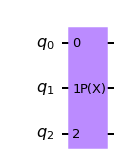

In [8]:
num_qubits = 3
interest_rate = 0.04

price_distribution = MaturityPriceDistribution(spot, volatility, interest_rate, T)

# demonstrate discretized price distribution
price_distribution_circuit = create_price_distribution_circuit(num_qubits, price_distribution)
price_distribution_circuit.draw()


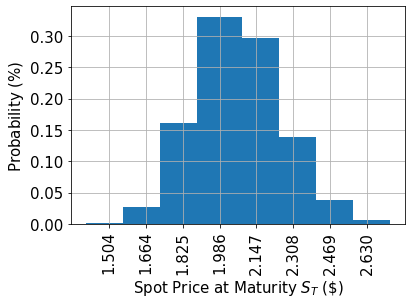

[(1.5035503108185861, 0.0011673611848710304), (1.6644920066171642, 0.02738394161756621), (1.8254337024157423, 0.16150249355560523), (1.9863753982143204, 0.3304083880075169), (2.1473170940128985, 0.29608829425744587), (2.3082587898114766, 0.13818780540099032), (2.4692004856100547, 0.03829247355342391), (2.6301421814086328, 0.006969242422580635)]
0.18506787120120835


In [9]:
# plot probability distribution
plot_price_distribution(price_distribution_circuit, print_values=True)
print(compute_exact_expected_payout(price_distribution_circuit, strike))

Now that $|q_0q_1q_2\rangle$ is in superposition $\sum_{i=0}^{7}\sqrt{p_i}|S_i\rangle$, we need to apply the payout function

In [10]:
def create_european_call_expected_payout_circuit(num_qubits: int, price_distribution: MaturityPriceDistribution, strike: float, c_approx: float):
    breakpoints = [price_distribution.low, strike] # domain = 2 pieces: [low, strike) and [strike, inf)
    slopes = [0, 1] # [low, strike) has constant 0 and [strike, inf) is the identity function
    offsets = [0, 0]
    f_min = 0 # minimum payout
    f_max = price_distribution.high - strike # max payout
    return LinearAmplitudeFunction(
        num_qubits,
        slopes,
        offsets,
        domain=[price_distribution.low, price_distribution.high],
        image=[f_min, f_max],
        breakpoints=breakpoints,
        rescaling_factor=c_approx
    )

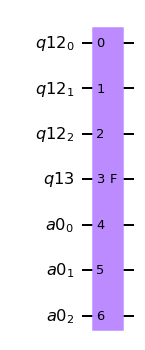

In [11]:
european_call_expected_payout_circuit = create_european_call_expected_payout_circuit(num_qubits, price_distribution, strike, 1.5)
european_call_expected_payout_circuit.draw()

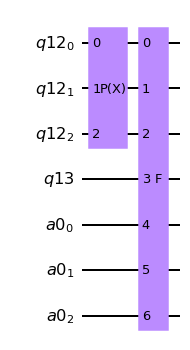

In [12]:
# stitch the distribution loading circuit with the payout calc
european_call_expected_payout_circuit.compose(price_distribution_circuit, front=True).draw()

In [13]:
def compute_european_call_expected_payout(initial_spot, strike, volatility, interest_rate, T, num_qubits, c_approx, backend, use_qiskit_lib=False):
    # first, create a price distribution
    price_distribution = MaturityPriceDistribution(initial_spot, volatility, interest_rate, T)
    distribution_loading_circuit = create_price_distribution_circuit(num_qubits, price_distribution)
    if use_qiskit_lib:
        # using qiskit finance's implementation
        european_call_objective = EuropeanCallPricing(
            num_qubits,
            strike,
            rescaling_factor=c_approx,
            bounds=(price_distribution.low, price_distribution.high),
            uncertainty_model=distribution_loading_circuit
           )

        # append the uncertainty model to the front
        estimation_problem = european_call_objective.to_estimation_problem()
    else:
        european_call_expected_payout_circuit = create_european_call_expected_payout_circuit(num_qubits, price_distribution, strike, c_approx)
        state_prep_circuit = european_call_expected_payout_circuit.compose(distribution_loading_circuit, front=True)
    
        # construct an estimation problem from the above circuit
        estimation_problem = EstimationProblem(
            state_prep_circuit,
            [num_qubits],
            post_processing=european_call_expected_payout_circuit.post_processing
        )

    # backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)

    iae = IterativeAmplitudeEstimation(
        epsilon_target = .01,
        alpha = .05,
        quantum_instance = quantum_instance)

    iae_result = iae.estimate(estimation_problem)
    return iae_result

In [14]:
# now test our implementation and compare with qiskit's implementation
initial_spot = 2.0
strike = 1.9
volatility = .1
interest_rate = .04
T = 300/365
num_qubits = 3
c_approx = 1.2
backend = Aer.get_backend("statevector_simulator")

my_result = compute_european_call_expected_payout(initial_spot, strike, volatility, interest_rate, T, num_qubits, c_approx, backend)
qiskit_result = compute_european_call_expected_payout(initial_spot, strike, volatility, interest_rate, T, num_qubits, c_approx, backend, True)

print("My results:")
print(my_result.estimation)
print(my_result.confidence_interval)

print("Qiskit's results:")
print(qiskit_result.estimation)
print(qiskit_result.confidence_interval)

My results:
0.19652649626068772
(0.19652649626068772, 0.19652649626068772)
Qiskit's results:
0.19652649626068772
(0.19652649626068772, 0.19652649626068772)


In [15]:
for n in [3, 5, 7, 9]:
    my_result = compute_european_call_expected_payout(initial_spot, strike, volatility, interest_rate, T, n, c_approx, backend)
    print(f"num_qubit={n}")
    print(my_result.estimation)
    print(my_result.confidence_interval)

num_qubit=3
0.19652649626068772
(0.19652649626068772, 0.19652649626068772)
num_qubit=5
0.19699965152554008
(0.19699965152554008, 0.19699965152554008)
num_qubit=7
0.1965236531971218
(0.1965236531971218, 0.1965236531971218)
num_qubit=9
0.19641995968461262
(0.19641995968461262, 0.19641995968461262)
